In [2]:
import ROOT
import os
import time
import matplotlib.pyplot as plt
import csv

Welcome to JupyROOT 6.24/06


In [115]:
path = "../merged_old/"

In [40]:
def get_total_size(path, n_files):
    filenames = sorted(os.listdir(path))
    total_size = sum([os.path.getsize(path + filenames[i]) for i in range(n_files)])
    return total_size / (2**30)

In [41]:
def col_average(data):
    n_rows = len(data)
    n_cols = len(data[0])
    return [sum([data[i][j] for i in range(1, n_rows)]) / (n_rows - 1) for j in range(n_cols)]

In [42]:
def col_standard_deviation(data):
    n_rows = len(data)
    n_cols = len(data[0])
    mean = col_average(data)
    return [(sum([(data[i][j] - mean[j])**2 for i in range(1, n_rows)]) / (n_rows - 1))**0.5 for j in range(n_cols)]
    

In [43]:
def runtime_measure(path, n_files, n_threads):
    # Specify the number of threads
    ROOT.ROOT.EnableImplicitMT(n_threads)
    
    # Get paths to all the files to be read 
    filenames = sorted(os.listdir(path))
    files_to_read = ROOT.std.vector('string')()
    for i in range(n_files):
        files_to_read.push_back(path + filenames[i])
    
    # Measure runtime
    start_time = time.time()
    data = ROOT.RDataFrame("rootuple/CandidateTree", files_to_read)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    np_array = cut.AsNumpy(["candidate_vMass"])
    runtime = time.time() - start_time
    
    return runtime
    

In [44]:
import multiprocessing
import numpy as np
import concurrent.futures

In [70]:
def to_numpy(files, result):
    if files.empty(): return
    data = ROOT.RDataFrame("rootuple/CandidateTree", files)
    cut = data.Filter("candidate_charge == 0")\
          .Filter("candidate_cosAlpha > 0.99")\
          .Filter("candidate_vProb > 0.05")\
          .Filter("candidate_lxy / candidate_lxyErr > 3.0")\
          .Filter("ditrack_mass > 1.014")\
          .Filter("ditrack_mass < 1.024")\
          .Filter("candidate_vMass > 5.33")\
          .Filter("candidate_vMass < 5.40")
    result.append(cut.AsNumpy(["candidate_vMass"])["candidate_vMass"])


In [46]:
def partition_files(path, n_files, n_processes):
    filenames = sorted(os.listdir(path))
    partitions = []
    curr = 0
    for i in range(n_processes):
        if i >= n_files: break
        n_files_in_partition = n_files // n_processes if i >= n_files % n_processes else n_files // n_processes + 1
        files_to_read = ROOT.std.vector('string')()
        for j in range(n_files_in_partition):
            files_to_read.push_back(path + filenames[curr + j])
        curr += n_files_in_partition
        partitions.append(files_to_read)
    return partitions

In [121]:
def runtime_measure_mp(path, n_files, n_processes):
    # Measure runtime
    partitions = partition_files(path, n_files, n_processes)
    start_time = time.time()
    processes = []
    result = multiprocessing.Manager().list()
    for partition in partitions:
        p = multiprocessing.Process(target=to_numpy, args=[partition, result])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
     
    np.concatenate(tuple(result))
    runtime = time.time() - start_time
    
    return runtime
# , np.concatenate(tuple(result))

In [48]:
def runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, i, n_threads) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)


In [49]:
def runtime_vs_size_plot(path, n_threads, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_%d_%d_%d_%d.csv" % (target_dir, n_threads, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size(path, n_threads, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Size (%d threads)' % (n_threads))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data), yerr=col_standard_deviation(data), fmt="o", ecolor="orange")
        plt.savefig('figures/rdf/%s/runtime_vs_size_%d_%d_%d_%d.png' % (target_dir, n_threads, max_files, step, n_loops), bbox_inches='tight')


In [58]:
def runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    x = [a for a in range(step, max_threads + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure(path, n_files, i) for i in range(step, max_threads + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)
        

In [78]:
def runtime_vs_threads_plot(path, n_files, max_threads, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_threads_%d_%d_%d_%d.csv" % (target_dir, n_files, max_threads, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_threads(path, n_files, max_threads, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Threads (%.2f GB)' % (get_total_size(path, n_files)))
        plt.xlabel('Threads')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, max_threads + 1, step))
        plt.gca().set_ylim([0, 50])
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_threads_%d_%d_%d_%d.png' % (target_dir, n_files, max_threads, step, n_loops), bbox_inches='tight')

In [68]:
def runtime_vs_processes(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    x = [a for a in range(step, n_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, n_files, i) for i in range(step, n_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [67]:
def runtime_vs_processes_plot(path, n_files, step, n_loops, target_dir):
    parent_dir = path.split('/')[-2]
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_processes_%d_%d_%d.csv" % (target_dir, n_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_processes(path, n_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Processes (%.2f GB)' % (get_total_size(path, n_files)))
        plt.xlabel('Processes')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.xticks(range(step, n_files + 1, step))
        plt.errorbar(data[0], col_average(data[:]), yerr=col_standard_deviation(data[:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[:])[i], 2), (data[0][i], col_average(data[:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_processes_%d_%d_%d.png' % (target_dir, n_files, step, n_loops), bbox_inches='tight')

In [21]:
def runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir):
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    x = [get_total_size(path, a) for a in range(step, max_files + step, step)]
    with open(result_path, "w+", newline="") as f:
        csv.writer(f).writerow(x)
    for n in range(n_loops):
        y = [runtime_measure_mp(path, i, n_processes) for i in range(step, max_files + step, step)]
        with open(result_path, "a+", newline="") as f:
            csv.writer(f).writerow(y)

In [124]:
def runtime_vs_size_plot_mp(path, n_processes, max_files, step, n_loops, target_dir):
    if not os.path.exists("runtime_tests_rdf/%s" % (target_dir)):
        os.mkdir("runtime_tests_rdf/%s" % (target_dir))
    if not os.path.exists("figures/rdf/%s" % (target_dir)):
        os.mkdir("figures/rdf/%s" % (target_dir))
    result_path = ("runtime_tests_rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.csv" % (target_dir, n_processes, max_files, step, n_loops))
    if not os.path.exists(result_path):
        runtime_vs_size_mp(path, n_processes, max_files, step, n_loops, target_dir)
    with open(result_path, "r") as f:
        data = [[float(a) for a in row] for row in csv.reader(f)]
        plt.figure(figsize = (15, 5))
        plt.title('Runtime vs Size (%d processes)' % (n_processes))
        plt.xlabel('Size (GB)')
        plt.ylabel('Runtime (s)')
        #plt.scatter(data[0], col_average(data))
        #for r in range(1, len(data)):
            #plt.scatter(data[0], data[r])
        plt.errorbar(data[0], col_average(data[1:]), yerr=col_standard_deviation(data[1:]), fmt="o", ecolor="orange")
        for i in range(len(data[0])): 
            plt.annotate(round(col_average(data[1:])[i], 2), (data[0][i], col_average(data[1:])[i]))
        plt.savefig('figures/rdf/%s/runtime_vs_size_mp_%d_%d_%d_%d.png' % (target_dir, n_processes, max_files, step, n_loops), bbox_inches='tight')

In [109]:
#runtime_vs_threads_plot(path, 10, 10, 1, 10, "merged")

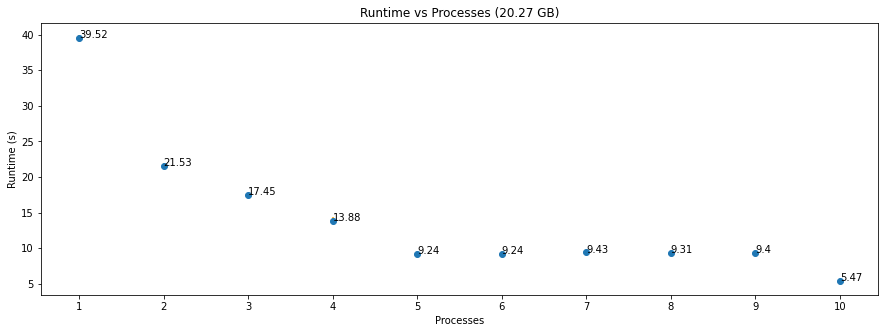

In [110]:
runtime_vs_processes_plot(path, 10, 1, 10, "merged")

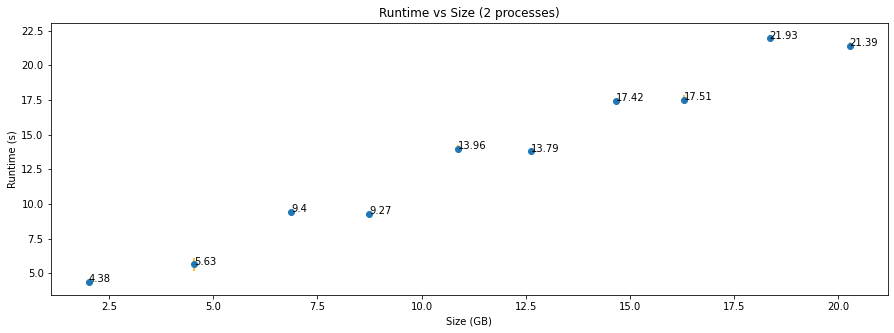

In [111]:
runtime_vs_size_plot_mp(path, 2, 10, 1, 5, "merged")

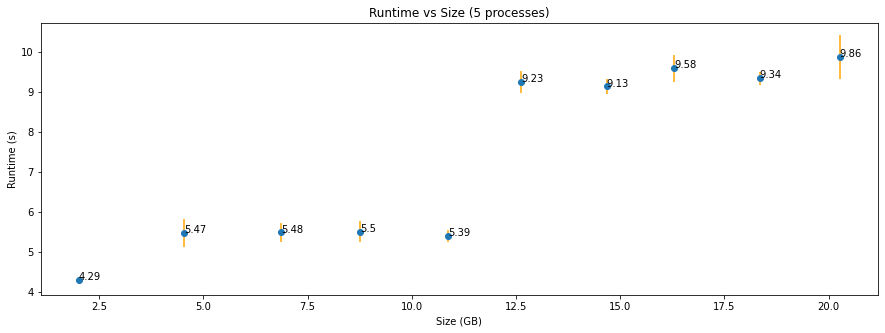

In [112]:
runtime_vs_size_plot_mp(path, 5, 10, 1, 5, "merged")